# Data Understanding

## Import Libraries

In [146]:
from sklearn import cross_validation, grid_search, linear_model,svm, metrics,preprocessing,pipeline
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

import numpy as np
import pandas as pd
import re
# будем отображать графики прямо в jupyter'e
%pylab inline
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


## Load data

In [132]:
train_df = pd.read_csv('train.csv', header = 0, sep = ',')
test_df = pd.read_csv('test.csv', header = 0, sep = ',')
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [133]:
train_df.shape

(891, 12)

In [134]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [135]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Feature Engineering
№ | Код | Название | Примечание
  ------------- | ------------- | -------------
1 | survival | выжил   | 0 = Нет, 1 = Да
2 | pclass  | Класс билета| 1,2,3
3 | sex	| Пол |	male, female
4|Age| Возраст в годах |
5|sibsp	| Количество братьев, сестер, супруг на борту Титаника |
6|parch | Количество родилетей/детей на борту Титаника |
7|ticket | # билета |
8|fare | Стоимость билета |
9|cabin | № каюты |
10|embarked	| Порт посадки | C = Cherbourg, Q = Queenstown, S = Southampton

In [136]:
train_df = train_df.drop(['PassengerId','Ticket'], axis=1)
test_df = train_df.drop(['Ticket'], axis=1)
train_df.head(5)

ValueError: labels ['Ticket'] not contained in axis

### 1. Каюта

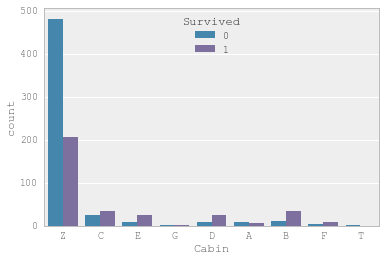

In [137]:
def eng_Cabin(df,plot):
    labelEnc=LabelEncoder()
    df['Cabin']=df['Cabin'].fillna('Z')
    df['Cabin']=df['Cabin'].apply(lambda x:x[0])
    if plot:
        sns.countplot(x='Cabin', hue='Survived', data=df);
    df['Cabin']=labelEnc.fit_transform(df['Cabin'])
    return df

train_df=eng_Cabin(train_df,True)
test_df=eng_Cabin(test_df,False)

### 2.Класс

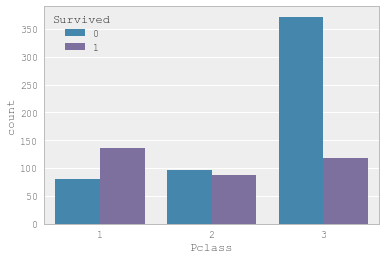

In [138]:
def eng_Class(df,plot):
    if plot: sns.countplot(x='Pclass', hue='Survived', data=df);
    dummies=pd.get_dummies(df['Pclass'])
    dummies.columns = ['Class_1','Class_2','Class_3']
    df=df.join(dummies)
    df.drop(['Pclass'], axis=1,inplace=True)
    return df

train_df=eng_Class(train_df,True)
test_df=eng_Class(test_df,False)

### 3.Возраст

#### Пробуем добораться возраст по полу
df_age=raw_data[['Sex','Age']]
male_age_mean=df_age[df_age['Sex']=='male']['Age'].mean()
female_age_mean=df_age[df_age['Sex']=='female']['Age'].mean()
df_age_male=df_age[df_age['Sex']=='male'][['Age']].fillna(male_age_mean)
df_age_female=df_age[df_age['Sex']=='female'][['Age']].fillna(female_age_mean)
df_age=df_age_male.append(df_age_female)
df_age=df_age.sort_index()


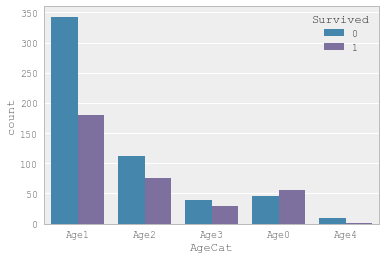

In [139]:
def age_convert(age):
    if age<=16:   return 0
    elif age<=32: return 1
    elif age<=48: return 2
    elif age<=64: return 3
    else:         return 4
    
def age_convert1(age):
    if age<=16:
        return 0
    elif age<=12:
        return 1
    elif age<=19:
        return 2
    elif age<=25:
        return 3
    elif age<=30:
        return 4
    elif age<=35:
        return 5
    elif age<=60:
        return 6
    else: 
        return 7
    
def eng_Age(df,plot):  
    df['Age']=df['Age'].fillna(df['Age'].mean())
    df['AgeCat']=df['Age'].apply(age_convert)
    df['AgeCat']=df['AgeCat'].apply(lambda x:'Age'+str(x))
    if plot: sns.countplot(x='AgeCat', hue='Survived', data=df);
    # Делаем массив бинарных признаков
    dummies=pd.get_dummies(df['AgeCat'],prefix='',prefix_sep='')
    df=df.join(dummies)
    df.drop(['AgeCat'], axis=1,inplace=True)
    return df

train_df=eng_Age(train_df,True)
test_df=eng_Age(test_df,False)

### 4. Порт посадки

,Survived,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Class_1,Class_2,Class_3,Age0,Age1,Age2,Age3,Age4,Embarked_C,Embarked_Q,Embarked_S
0,0,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,8,0,0,1,0,1,0,0,0,0,0,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,2,1,0,0,0,0,1,0,0,1,0,0
2,1,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,8,0,0,1,0,1,0,0,0,0,0,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,2,1,0,0,0,0,1,0,0,0,0,1
4,0,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,8,0,0,1,0,0,1,0,0,0,0,1


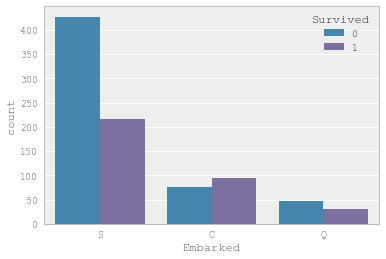

In [140]:
def eng_Emb(df,plot):  
    df['Embarked'].fillna('C',inplace=True)
    if plot:sns.countplot(x='Embarked', hue='Survived', data=df);
    dummies=pd.get_dummies(df['Embarked'],prefix='Embarked')
    df=df.join(dummies)
    df.drop(['Embarked'], axis=1,inplace=True)
    return df

train_df=eng_Emb(train_df,True)
test_df=eng_Emb(test_df,False)
train_df.head(5)

### 5. Семья

In [141]:
def eng_Family(df,plot):  
    df['Family']=df["SibSp"]+df["Parch"]
    df['IsAlone'] = 0
    df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1
    df.drop(['SibSp','Parch'],axis=1,inplace=True)
    if plot:sns.countplot(x='Family', hue='Survived', data=df);
    return df

train_df=eng_Family(train_df,True)
test_df=eng_Family(test_df,False)
train_df.head(5)

KeyError: 'FamilySize'

### 6.Title

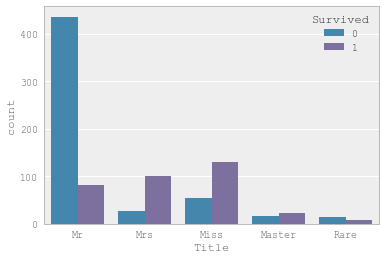

In [142]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""


def eng_Title(df,plot):  
    df['Title']= df['Name'].apply(get_title)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    if plot:sns.countplot(x='Title', hue='Survived', data=df);
    dummies=pd.get_dummies(df['Title'],prefix='Title')
    df=df.join(dummies)
    df.drop(['Name','Title'], axis=1,inplace=True)
    return df

train_df=eng_Title(train_df,True)
test_df=eng_Title(test_df,False)

### 7. Пол

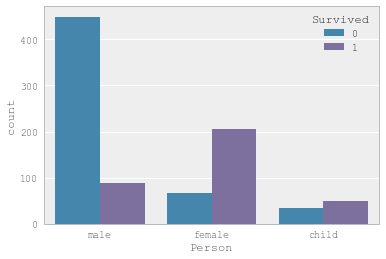

In [143]:
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex

def eng_Sex(df,plot):  
    df['Person'] = df[['Age','Sex']].apply(get_person,axis=1)
    if plot:sns.countplot(x='Person', hue='Survived', data=df);
    dummies=pd.get_dummies(df['Person'],prefix='Person')
    df=df.join(dummies)
    df.drop(['Sex','Age','Person'], axis=1,inplace=True)
    return df

train_df=eng_Sex(train_df,True)
test_df=eng_Sex(test_df,False)

### 8.Fare

In [144]:
def eng_Fare(df,plot):  
    df['Fare']=df['Fare'].fillna(df['Fare'].mean())
    df['Fare']=df['Fare'].apply(lambda x:int(x/20))
    return df

train_df=eng_Fare(train_df,True)
test_df=eng_Fare(test_df,False)

### 9. Ticket number

def cleanTicket( ticket ):
    ticket = ticket.replace( '.' , '' )
    ticket = ticket.replace( '/' , '' )
    ticket = ticket.split()
    ticket = map( lambda t : t.strip() , ticket )
    ticket = list(filter( lambda t : not t.isdigit() , ticket ))
    if len( ticket ) > 0:
        return ticket[0]
    else: 
        return 'XXX'

def eng_Ticket(df,plot):      
    ticket = pd.DataFrame()
    # Extracting dummy variables from tickets:
    ticket[ 'Ticket' ] = df['Ticket'].map( cleanTicket )
    ticket = pd.get_dummies( ticket[ 'Ticket' ] , prefix = 'Ticket' )
    df=df.join(ticket)
    df.drop(['Ticket'], axis=1,inplace=True)
    return df

train_df=eng_Ticket(train_df,True)
test_df=eng_Ticket(test_df,False)
train_df.head(5)

## Modeling

### Split

In [128]:
X_train = train_df.drop(['Survived'],axis=1)
y_train = train_df['Survived']
X_test  = test_df.drop("PassengerId",axis=1).copy()

X_train_train,X_train_holdout,y_train_train,y_train_holdout=cross_validation.train_test_split(
    X_train, y_train, test_size=0.33, random_state=1)
print ("X_train=",X_train.shape,X_train_train.shape,X_train_holdout.shape)
print ("y_train=",y_train.shape,y_train_train.shape,y_train_holdout.shape)

X_train= (891, 24) (596, 24) (295, 24)
y_train= (891,) (596,) (295,)


### Модели

In [129]:
def score_model(name,estimator,cv_strategy,fit):
    #создаем pipeline из двух шагов: scaling и классификация
    #est = pipeline.Pipeline(steps = [('scaling', preprocessing.StandardScaler(with_mean = 0)), ('regression', regressor)])
    # Обучение на train, выводим точность классификатора на отложенном тесте
    if fit: estimator.fit(X_train_train, y_train_train)
    predictions=estimator.predict(X_train_holdout)
    acc_score=metrics.accuracy_score(y_train_holdout,predictions)
    f1_score= metrics.f1_score(y_train_holdout, predictions)
    roc_auc_score=metrics.roc_auc_score(y_train_holdout, predictions)
    prc_auc_score=metrics.average_precision_score(y_train_holdout, predictions)
    # Точность на кросс валидации (на полном тесте)
    cv_scoring = cross_validation.cross_val_score(estimator, X_train, y_train, scoring = 'accuracy', cv = cv_strategy)
    return name,round(cv_scoring.mean(),3),round(acc_score,3),round(f1_score,3),round(roc_auc_score,3),round(prc_auc_score,3),

def rank_models(models,fit=True):
    cv_strategy = cross_validation.StratifiedShuffleSplit(y_train, n_iter = 10 , test_size = 0.33, random_state = 1)
    result=pd.DataFrame(columns=['Name',"CV_acc","acc","f1","roc_auc","prc_auc"])
    for model in models:
        score=score_model(model[0],model[1],cv_strategy,fit)
        result.loc[len(result)]=score
    result['CV_Rank'] = result['CV_acc'].rank(ascending=0)    
    result['Acc_Rank'] = result['acc'].rank(ascending=0)    
    result['f1_Rank'] = result['f1'].rank(ascending=0)    
    result['roc_auc_Rank'] = result['roc_auc'].rank(ascending=0)    
    result['prc_auc_Rank'] = result['prc_auc'].rank(ascending=0)   
    result['Rank_score']=result[['CV_Rank','Acc_Rank','f1_Rank','roc_auc_Rank','prc_auc_Rank']].sum(axis=1)
    return result

In [147]:
models=(
        ("LinearLogisticRegression",linear_model.LogisticRegression(random_state = 1)),
        #("LinearRidgeClassifier",linear_model.RidgeClassifier(random_state = 1)),
        #("LinearSVC",svm.LinearSVC(random_state=1)),
        #("NuSVC",svm.NuSVC(random_state=1)),
        ("SVC-rbf",svm.SVC(kernel='rbf',random_state=1)),
        #("SVC-sigmoid",svm.SVC(kernel='sigmoid',random_state=1)),
        #("SVC-poly",svm.SVC(kernel='poly',random_state=1)),   
        ("RandomForestClassifier",RandomForestClassifier(n_estimators=10)),
        ("GradientBoostingClassifier",GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0))
        # ("RandomForestClassifier",RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)) 
)
all_models_score=rank_models(models)
all_models_score.sort_values(by='CV_acc',  ascending=False)

,Name,CV_acc,acc,f1,roc_auc,prc_auc,CV_Rank,Acc_Rank,f1_Rank,roc_auc_Rank,prc_auc_Rank,Rank_score
0,LinearLogisticRegression,0.830,0.786,0.722,0.770,0.792,1.0,2.0,3.0,3.0,2.0,11.0
1,SVC-rbf,0.829,0.790,0.723,0.771,0.796,2.0,1.0,2.0,2.0,1.0,8.0
3,GradientBoostingClassifier,0.817,0.783,0.729,0.772,0.789,3.0,3.0,1.0,1.0,3.0,11.0
2,RandomForestClassifier,0.803,0.780,0.700,0.757,0.786,4.0,4.0,4.0,4.0,4.0,20.0


## Подбор параметров

In [78]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

### SVC-rbf

In [22]:
# Параметры
svc_param_grid = {"C": np.logspace(-2, 5, 8),
              "gamma": np.logspace(-9, 3, 13)}
svc_grid = GridSearchCV(estimator=svm.SVC(kernel='rbf',random_state=1), param_grid=svc_param_grid, cv=5,verbose=10)
svc_grid.fit(X_train_train, y_train_train)
print("The best parameters are %s with a score of %0.2f"
      % (svc_grid.best_params_, svc_grid.best_score_))

Fitting 5 folds for each of 104 candidates, totalling 520 fits
[CV] gamma=1e-09, C=0.01 .............................................
[CV] .............. gamma=1e-09, C=0.01, score=0.625000, total=   0.0s
[CV] gamma=1e-09, C=0.01 .............................................
[CV] .............. gamma=1e-09, C=0.01, score=0.630252, total=   0.0s
[CV] gamma=1e-09, C=0.01 .............................................
[CV] .............. gamma=1e-09, C=0.01, score=0.630252, total=   0.0s
[CV] gamma=1e-09, C=0.01 .............................................
[CV] .............. gamma=1e-09, C=0.01, score=0.630252, total=   0.0s
[CV] gamma=1e-09, C=0.01 .............................................
[CV] .............. gamma=1e-09, C=0.01, score=0.630252, total=   0.0s
[CV] gamma=1e-08, C=0.01 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s


[CV] .............. gamma=1e-08, C=0.01, score=0.625000, total=   0.0s
[CV] gamma=1e-08, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.630252, total=   0.0s
[CV] gamma=1e-08, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.630252, total=   0.0s
[CV] gamma=1e-08, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.630252, total=   0.0s
[CV] gamma=1e-08, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.630252, total=   0.0s
[CV] gamma=1e-07, C=0.01 .............................................
[CV] .............. gamma=1e-07, C=0.01, score=0.625000, total=   0.0s

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s



[CV] gamma=1e-07, C=0.01 .............................................
[CV] .............. gamma=1e-07, C=0.01, score=0.630252, total=   0.0s
[CV] gamma=1e-07, C=0.01 .............................................
[CV] .............. gamma=1e-07, C=0.01, score=0.630252, total=   0.0s
[CV] gamma=1e-07, C=0.01 .............................................
[CV] .............. gamma=1e-07, C=0.01, score=0.630252, total=   0.0s
[CV] gamma=1e-07, C=0.01 .............................................
[CV] .............. gamma=1e-07, C=0.01, score=0.630252, total=   0.0s
[CV] gamma=1e-06, C=0.01 .............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.625000, total=   0.0s
[CV] gamma=1e-06, C=0.01 .............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.630252, total=   0.0s
[CV] gamma=1e-06, C=0.01 .............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.630252, total=   0.0s
[CV] 

KeyboardInterrupt: 

In [ ]:
#result.sort_values(by='CV_acc',  ascending=False)
best_est=pd.DataFrame(svc_grid.cv_results_)
best_est=best_est[best_est['rank_test_score']<=5]
best_est=best_est[['params','rank_test_score']].as_matrix()
best_est_list=list()
for i in range(len(best_est)):
    params=best_est[i,0]
    num=best_est[i,1]
    param_C=params['C']
    param_gamma=params['gamma']
    best_est_list.append(('SVC_rbf_'+str(num),svm.SVC(kernel='rbf',random_state=1,gamma=param_gamma,C=param_C)))
svc_models_score=rank_models(best_est_list,True)
all_models_score=all_models_score.append(svc_models_score)
all_models_score.sort_values(by='acc',  ascending=False)

### LinearLogisticRegression 

In [ ]:
# Параметры
linlog_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              "penalty": ['l1','l2']}
linlog_grid = GridSearchCV(linear_model.LogisticRegression(random_state = 1), param_grid=linlog_param_grid, cv=10,verbose=10)
linlog_grid.fit(X_train_train, y_train_train)
print("The best parameters are %s with a score of %0.2f"
 % (linlog_grid.best_params_, linlog_grid.best_score_))

In [ ]:
def get_models(name,grid):
    best_est=pd.DataFrame(grid.cv_results_)
    best_est=best_est[best_est['rank_test_score']<=5]
    best_est=best_est[['params','rank_test_score']].as_matrix()
    best_est_list=list()
    for i in range(len(best_est)):
        params=best_est[i,0]
        num=best_est[i,1]
        param_C=params['C']
        param_penalty=params['penalty']
        best_est_list.append((name+str(num),linear_model.LogisticRegression(random_state=1,penalty=param_penalty,C=param_C)))
    return rank_models(best_est_list,True),best_est_list
    
models,lin_est=get_models('linlog',linlog_grid)
all_models_score=all_models_score.append(models)
all_models_score.sort_values(by='CV_acc',  ascending=False)

### RandomForest

In [79]:
# Utility function to report best scores

rf_param_grid = {"max_depth": [3,5,10, None],
             "n_estimators": [10, 50,100]}

In [80]:
rf_grid = GridSearchCV(RandomForestClassifier(), param_grid=rf_param_grid, cv= 10)
rf_grid.fit(X_train_train, y_train_train)
report(rf_grid.cv_results_)
print (rf_grid.best_score_,rf_grid.best_params_)

Model with rank: 1
Mean validation score: 0.857 (std: 0.034)
Parameters: {'max_depth': 10, 'n_estimators': 100}

Model with rank: 2
Mean validation score: 0.856 (std: 0.023)
Parameters: {'max_depth': 10, 'n_estimators': 50}

Model with rank: 3
Mean validation score: 0.849 (std: 0.036)
Parameters: {'max_depth': 5, 'n_estimators': 100}

Model with rank: 4
Mean validation score: 0.847 (std: 0.036)
Parameters: {'max_depth': None, 'n_estimators': 50}

Model with rank: 5
Mean validation score: 0.846 (std: 0.040)
Parameters: {'max_depth': 5, 'n_estimators': 50}

0.857382550336 {'max_depth': 10, 'n_estimators': 100}


In [145]:
def get_models(name,grid):
    best_est=pd.DataFrame(grid.cv_results_)
    best_est=best_est[best_est['rank_test_score']<=5]
    best_est=best_est[['params','rank_test_score']].as_matrix()
    best_est_list=list()
    for i in range(len(best_est)):
        params=best_est[i,0]
        num=best_est[i,1]
        param_max_depth=params['max_depth']
        param_n_estimators=params['n_estimators']
        best_est_list.append((name+str(num),RandomForestClassifier(random_state=1,n_estimators=param_n_estimators,max_depth=param_max_depth)))
    return rank_models(best_est_list,True),best_est_list
    
models,rt_est=get_models('RT',rf_grid)
all_models_score=all_models_score.append(models)
all_models_score.sort_values(by='acc',  ascending=False)

,Name,CV_acc,acc,f1,roc_auc,prc_auc,CV_Rank,Acc_Rank,f1_Rank,roc_auc_Rank,prc_auc_Rank,Rank_score
1,RT3,0.842,0.800,0.728,0.778,0.809,1.0,1.0,1.0,1.0,1.0,5.0
1,RT3,0.842,0.800,0.728,0.778,0.809,1.0,1.0,1.0,1.0,1.0,5.0
0,RT5,0.841,0.793,0.726,0.774,0.800,2.0,2.0,2.0,2.0,2.0,10.0
0,RT5,0.841,0.793,0.726,0.774,0.800,2.0,2.0,2.0,2.0,2.0,10.0
1,SVC-rbf,0.829,0.790,0.723,0.771,0.796,2.0,1.0,1.0,1.0,1.0,6.0
0,LinearLogisticRegression,0.830,0.786,0.722,0.770,0.792,1.0,2.0,2.0,2.0,2.0,9.0
2,RandomForestClassifier,0.810,0.783,0.706,0.761,0.790,3.0,3.0,3.0,3.0,3.0,15.0
2,RT2,0.818,0.783,0.709,0.762,0.789,4.0,3.0,3.0,3.0,3.0,16.0
2,RT2,0.818,0.783,0.709,0.762,0.789,4.0,3.0,3.0,3.0,3.0,16.0
3,RT1,0.820,0.780,0.706,0.759,0.785,3.0,4.0,4.0,4.0,4.0,19.0


In [152]:
est_rf=rf_grid.best_estimator_
#est_svc=svc_grid.best_estimator_
#est_linlog=linlog_grid.best_estimator_
est_gb=gb_grid.best_estimator_
est_gb.fit()

### GradientBoostingClassifier

In [150]:
# Параметры
gb_param_grid = {'learning_rate': [0.1, 0.3, 0.5, 1],
              "n_estimators":[10, 50, 100, 200],
            "max_depth":[3,5,10,None]}
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state = 1), param_grid=gb_param_grid, cv=5)
gb_grid.fit(X_train_train, y_train_train)
print("The best parameters are %s with a score of %0.2f"
 % (gb_grid.best_params_, gb_grid.best_score_))

The best parameters are {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 10} with a score of 0.84


In [ ]:
def get_models(name,grid):
    best_est=pd.DataFrame(grid.cv_results_)
    best_est=best_est[best_est['rank_test_score']<=5]
    best_est=best_est[['params','rank_test_score']].as_matrix()
    best_est_list=list()
    for i in range(len(best_est)):
        params=best_est[i,0]
        num=best_est[i,1]
        param_max_depth=params['max_depth']
        param_n_estimators=params['n_estimators']
        best_est_list.append((name+str(num),RandomForestClassifier(random_state=1,n_estimators=param_n_estimators,max_depth=param_max_depth)))
    return rank_models(best_est_list,True),best_est_list
    
models,gb_est=get_models('GB',gb_grid)
all_models_score=all_models_score.append(models)
all_models_score.sort_values(by='acc',  ascending=False)



,

## Предсказываем результат

In [ ]:
#est=svm.SVC(kernel='rbf',random_state=1,C=10.0, gamma=0.01)
est=RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
est.fit(X_train_train,y_train_train)
print (est.score( X_train_train , y_train_train ) , est.score( X_train_holdout , y_train_holdout ))
# Feature importance
imp = pd.DataFrame( 
        est.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X_train_train.columns 
    )
imp = imp.sort_values( [ 'Importance' ] , ascending = True )
imp[ : 10 ].plot( kind = 'barh' )
print (est.score( X_train_train , y_train_train ))

#delete ftr
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(est, prefit=True)
X_train_new = model.transform(X_train_train)
X_holdout_new= model.transform(X_train_holdout)
X_test_new= model.transform(X_test) 
est.fit(X_train_new,y_train_train)
print (est.score( X_train_new , y_train_train ) , est.score( X_holdout_new , y_train_holdout ))

In [153]:
#est=RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
#est.fit(X_train,y_train)
est_gb.fit(X_train_train,y_train_train)
#est_linlog.fit(X_train,y_train)
#est_svc.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=10, presort='auto', random_state=1,
              subsample=1.0, verbose=0, warm_start=False)

In [154]:
def predict(est,prefix):
    Y_pred = est.predict(X_test)
    submission = pd.DataFrame({
            "PassengerId": test_df["PassengerId"],
            "Survived": Y_pred
        })
    submission.to_csv("result_"+prefix+".csv", index=False)
                    
#predict(est_linlog,"linlog-best")
#predict(est_rf,"rf-best")
#predict(est_svc,"svc-best")
#predict(est,"rf")    
predict(est_gb,"gb")  

ValueError: could not convert string to float: 'SOTON/O.Q. 3101262'